<a href="https://colab.research.google.com/github/murdockbleak/NN-Compression/blob/main/Seminar_5_Knowledge_Distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install torchdistill
# !pip install flopco-pytorch

# !gdown --id 1zFqrlK2WDPzZw5EyrjdOB-UWt5xOj-iS
# !tar -xf arxiv.tar
# !ls

!pip install torch torchvision tensorly==0.4.5 flopco-pytorch torchdistill

     |████████████████████████████████| 70 kB 3.4 MB/s 
     |████████████████████████████████| 81 kB 10.0 MB/s 
     |████████████████████████████████| 154 kB 38.3 MB/s 
     |████████████████████████████████| 596 kB 42.3 MB/s 
  Created wheel for tensorly: filename=tensorly-0.4.5-py3-none-any.whl size=100163 sha256=c89b226d84940620c49bcb64d0b038788f89087530409b2abde351c5fa3cd9ec
  Stored in directory: /root/.cache/pip/wheels/05/ed/36/493bba3faa150a1193eec864db4951355eb64659330cb00722
Successfully built tensorly
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt

%matplotlib inline


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

args={}
kwargs={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=5  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.1 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=60
args['cuda']=True


In [ ]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:

def train(model, epoch, optimizer, args = args):
    device = 'cuda' if args['cuda'] else 'cpu'
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.to(device), target.to(device)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.cross_entropy(output, target)
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, args = args):
    device = 'cuda' if args['cuda'] else 'cpu'
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in test_loader:
          if args['cuda']:
              data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += F.cross_entropy(output, target).item() # sum up batch loss
          pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
          correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return 100. * correct / len(test_loader.dataset)




# 0 Train Teacher model on MNIST

Credits: https://colab.research.google.com/github/rpi-techfundamentals/fall2018-materials/blob/master/10-deep-learning/04-pytorch-mnist.ipynb

## LeNet

At a high level, LeNet (LeNet-5) consists of two parts:
(i) a convolutional encoder consisting of two convolutional layers; and
(ii) a dense block consisting of three fully-connected layers;
The architecture is summarized in :numref:`img_lenet`.

![Data flow in LeNet. The input is a handwritten digit, the output a probability over 10 possible outcomes.](http://d2l.ai/_images/lenet.svg)

In [ ]:
class TeacherNetClass(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(TeacherNetClass, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()  #Dropout
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        #Convolutional Layer/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        #Convolutional Layer/Dropout/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 256)
        #Fully Connected Layer/Activation
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        #Fully Connected Layer/Activation
        x = self.fc2(x)
        #Softmax gets probabilities. 
        return x

In [ ]:
teacher = TeacherNetClass()
teacher.to(device)

optimizer = optim.SGD(teacher.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, 10 + 1):
    train(teacher, epoch, optimizer)
    test(teacher)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333757

Test set: Average loss: 0.0003, Accuracy: 9068/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.577211

Test set: Average loss: 0.0002, Accuracy: 9413/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.466357

Test set: Average loss: 0.0001, Accuracy: 9565/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.376105

Test set: Average loss: 0.0001, Accuracy: 9654/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.275484

Test set: Average loss: 0.0001, Accuracy: 9689/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.280345

Test set: Average loss: 0.0001, Accuracy: 9719/10000 (97%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.290522

Test set: Average loss: 0.0001, Accuracy: 9743/10000 (97%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.223848

Test set: Average loss: 0.0001, Accuracy: 9746/10000 (97%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.243584

Test set: Average loss: 0.0001, Accuracy: 9773/10000 (98%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.252053


# 1 Train Student Model without KD

We define Student's architecture same as Teacher's but with smaller number width in some layers

In [ ]:
class StudentNetClass(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(StudentNetClass, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 8, kernel_size=5)
        self.fc1 = nn.Linear(128, 16)
        self.fc2 = nn.Linear(16, 10)

    def forward(self, x):
        #Convolutional Layer/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) 
        #Convolutional Layer/Dropout/Pooling Layer/Activation
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 128)
        #Fully Connected Layer/Activation
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        #Fully Connected Layer/Activation
        x = self.fc2(x)
        #Softmax gets probabilities. 
        return x

In [ ]:
student = StudentNetClass()
student.to(device)
acc_list_wo_kd = []

optimizer = optim.SGD(student.parameters(), lr=args['lr'], momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train(student, epoch, optimizer)
    acc_list_wo_kd.append(test(student))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333591

Test set: Average loss: 0.0006, Accuracy: 8575/10000 (86%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.170461

Test set: Average loss: 0.0003, Accuracy: 9275/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.812199

Test set: Average loss: 0.0002, Accuracy: 9473/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.746055

Test set: Average loss: 0.0002, Accuracy: 9580/10000 (96%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.668411

Test set: Average loss: 0.0001, Accuracy: 9626/10000 (96%)



# 2 Train Student using Soft Trargets 

Total loss:

$\mathcal{L}=(1-\alpha) \mathcal{L}_{c e}\left(z_{s}, y\right)+\alpha \mathcal{L}_{k d}\left(z_{s}, z_{t}\right)$

Knowledge Distillation loss:

$\mathcal{L}_{k d}\left(z_{s}, z_{t}\right):= \tau^2 D_{KL} (SoftMax(z_{s}, \tau), SoftMax(z_{t}, \tau))$

In [ ]:
class SoftTarget(nn.Module):
	'''
	Distilling the Knowledge in a Neural Network
	https://arxiv.org/pdf/1503.02531.pdf
	'''
	def __init__(self, T):
		super(SoftTarget, self).__init__()
		self.T = T

	def forward(self, out_s, out_t):
		loss = F.kl_div(F.log_softmax(out_s/self.T, dim=1),
						F.softmax(out_t/self.T, dim=1),
						reduction='batchmean') * self.T * self.T

		return loss

In [ ]:
def train_st(teacher, student, epoch, optimizer, st_loss, alpha = 0.1, args = args):
    device = 'cuda' if args['cuda'] else 'cpu'
    teacher.to(device)
    teacher.eval()
    student.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.to(device), target.to(device)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = student(data)

        with torch.no_grad():
          output_t = teacher(data)

        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss_label = F.cross_entropy(output, target)
        # Calculate KD loss on soft targets
        loss_st = st_loss(output, output_t)

        loss = (1 - alpha) * loss_label + alpha * loss_st
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

## 2.1 Train Student

In [ ]:
student_st = StudentNetClass()
student_st.to(device)

T = 5
st_loss = SoftTarget(T)
alpha = 0.5

optimizer = optim.SGD(student_st.parameters(), lr=args['lr'], 
                      momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train_st(teacher, student_st, epoch, optimizer, st_loss, alpha)
    test(student_st)

Train Epoch: 1 [0/60000 (0%)]	Loss: 12.178682

Test set: Average loss: 0.0005, Accuracy: 8503/10000 (85%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 6.101085

Test set: Average loss: 0.0003, Accuracy: 9251/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 5.219643

Test set: Average loss: 0.0002, Accuracy: 9505/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 4.745596

Test set: Average loss: 0.0002, Accuracy: 9536/10000 (95%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 4.613980

Test set: Average loss: 0.0002, Accuracy: 9568/10000 (96%)



## 2.2 Check different temperatures for SoftMax

In [ ]:
Ts = [1, 5, 10, 20, 50]

exp_dict = {}

for T in Ts:
  print(f'__________(T = {T})_________')
  acc_list = []
  student_st = StudentNetClass()
  student_st.to(device)
  st_loss = SoftTarget(T)
  alpha = 0.5

  optimizer = optim.SGD(student_st.parameters(), lr=args['lr'], 
                        momentum=args['momentum'])

  for epoch in range(1, args['epochs'] + 1):
      train_st(teacher, student_st, epoch, optimizer, st_loss, alpha)
      acc_list.append(test(student_st))

  exp_dict[T] = acc_list

__________(T = 1)_________
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.269488

Test set: Average loss: 0.0005, Accuracy: 8534/10000 (85%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.014766

Test set: Average loss: 0.0003, Accuracy: 9294/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.698971

Test set: Average loss: 0.0002, Accuracy: 9468/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.564213

Test set: Average loss: 0.0002, Accuracy: 9505/10000 (95%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.566530

Test set: Average loss: 0.0002, Accuracy: 9562/10000 (96%)

__________(T = 5)_________
Train Epoch: 1 [0/60000 (0%)]	Loss: 12.275308

Test set: Average loss: 0.0003, Accuracy: 9249/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 4.839474

Test set: Average loss: 0.0002, Accuracy: 9382/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 4.338434

Test set: Average loss: 0.0002, Accuracy: 9535/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 4.153992

Test set: Average loss: 0.0001, Accuracy: 9559/1000

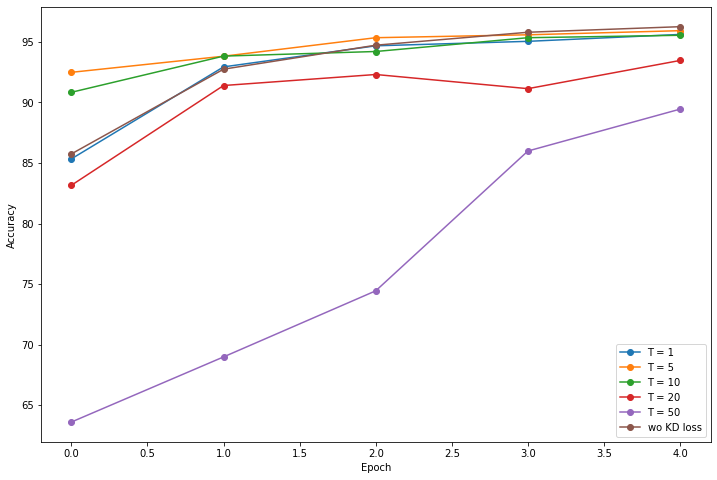

In [ ]:
plt.figure(figsize = (12, 8))

for T, acc_list in  exp_dict.items():
  plt.plot(acc_list, label = f'T = {T}', marker='o')

plt.plot(acc_list_wo_kd, label = f'wo KD loss', marker='o')

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

## 2.3 Check different Alphas

In [ ]:
alphas = [0, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.]

exp_dict = {}

for alphas in alphass:
  print(f'__________(aplha = {alphas})_________')
  acc_list = []
  student_st = StudentNetClass()
  student_st.to(device)
  T = 5
  st_loss = SoftTarget(T)

  optimizer = optim.SGD(student_st.parameters(), lr=args['lr'], 
                        momentum=args['momentum'])

  for epoch in range(1, args['epochs'] + 1):
      train_st(teacher, student_st, epoch, optimizer, st_loss, alphas)
      acc_list.append(test(student_st))

  exp_dict[alphas] = acc_list

__________(aplha = 0)_________
Train Epoch: 1 [0/60000 (0%)]	Loss: 11.949616

Test set: Average loss: 0.0005, Accuracy: 8110/10000 (81%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 6.787769

Test set: Average loss: 0.0003, Accuracy: 9034/10000 (90%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 5.531361

Test set: Average loss: 0.0002, Accuracy: 9341/10000 (93%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 4.921432

Test set: Average loss: 0.0002, Accuracy: 9272/10000 (93%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 5.350637

Test set: Average loss: 0.0002, Accuracy: 9400/10000 (94%)

__________(aplha = 0.05)_________
Train Epoch: 1 [0/60000 (0%)]	Loss: 12.274556

Test set: Average loss: 0.0004, Accuracy: 8612/10000 (86%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 5.706718

Test set: Average loss: 0.0002, Accuracy: 9385/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 4.720350

Test set: Average loss: 0.0002, Accuracy: 9510/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 4.034681

Test set: Average loss: 0.0001, Accurac

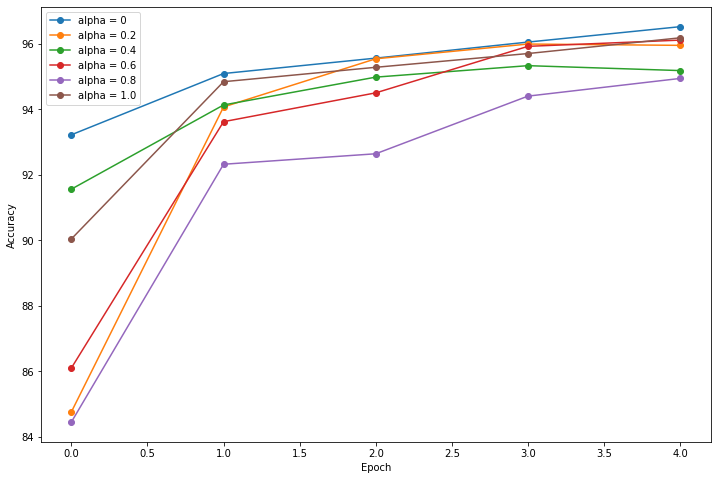

In [ ]:
plt.figure(figsize = (12, 8))

for alpha, acc_list in  exp_dict.items():
  plt.plot(acc_list, label = f'alpha = {alpha}', marker='o')

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# 3 Train Student with Hint loss

$\mathcal{L}=(1-\alpha) \mathcal{L}_{c e}\left(z_{s}, y\right)+\alpha \mathcal{L}_{H T}\left(h_{s}, h_{t}\right)$

$\mathcal{L}_{H T}\left(\mathbf{W}_{\text {Guided }}, \mathbf{W}_{\mathbf{r}}\right)=\frac{1}{2}\left\|u_{h}\left(\mathbf{x} ; \mathbf{W}_{\text {Hint }}\right)-r\left(v_{g}\left(\mathbf{x} ; \mathbf{W}_{\text {Guided }}\right) ; \mathbf{W}_{\mathbf{r}}\right)\right\|^{2}$


## 3.1 Forward Hook

But first, let's check how can can we extract intermediate features of teacher

In [ ]:
teacher

TeacherNetClass(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
from torchdistill.core.forward_hook import ForwardHookManager

# Define a forward hook manager
forward_hook_manager_teacher = ForwardHookManager(device)

# We want to track "conv1": output
forward_hook_manager_teacher.add_hook(teacher, 'conv1', requires_input=False, 
                                      requires_output=True)

# Execute forward function of the model
teacher.eval()

x = torch.rand(1, 1, 28, 28).to(device)
with torch.no_grad():
  y = teacher(x)

# Get I/O dictionary from the manager
teacher_io_dict = forward_hook_manager_teacher.pop_io_dict()



# Inspect dictionary
# teacher_io_dict

In [ ]:
teacher_io_dict['conv1']['output'].shape

torch.Size([1, 8, 24, 24])

In [ ]:
# remove hook
forward_hook_manager_teacher.clear()

## 3.2 Define Hint loss

$\mathcal{L}_{H T}\left(\mathbf{W}_{\text {Guided }}, \mathbf{W}_{\mathbf{r}}\right)=\frac{1}{2}\left\|u_{h}\left(\mathbf{x} ; \mathbf{W}_{\text {Hint }}\right)-r\left(v_{g}\left(\mathbf{x} ; \mathbf{W}_{\text {Guided }}\right) ; \mathbf{W}_{\mathbf{r}}\right)\right\|^{2}$

In [ ]:
class Hint(nn.Module):
	'''
	FitNets: Hints for Thin Deep Nets
	https://arxiv.org/pdf/1412.6550.pdf
	'''
	def __init__(self):
		super(Hint, self).__init__()

	def forward(self, fm_s, fm_t):
		loss = F.mse_loss(fm_s, fm_t)

		return loss

In [ ]:
def train_hint(teacher, student, epoch, optimizer, hint_loss, 
               forward_hook_manager_teacher,
               forward_hook_manager_student,
               alpha = 0.1, args = args):
    device = 'cuda' if args['cuda'] else 'cpu'
    teacher.to(device)
    teacher.eval()
    student.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.to(device), target.to(device)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = student(data)

        with torch.no_grad():
          output_t = teacher(data)

        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss_label = F.cross_entropy(output, target)
        # Calculate Hint loss on soft targets
        teacher_io_dict = forward_hook_manager_teacher.pop_io_dict()
        student_io_dict = forward_hook_manager_student.pop_io_dict()

        loss_hint = hint_loss(student_io_dict['conv1']['output'], 
                              teacher_io_dict['conv1']['output'])

        loss = (1 - alpha) * loss_label + alpha * loss_hint
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
forward_hook_manager_teacher = ForwardHookManager(device)
forward_hook_manager_student = ForwardHookManager(device)

student_hint = StudentNetClass()
student_hint.to(device)

forward_hook_manager_teacher.add_hook(teacher, 'conv1', requires_input=False, 
                                      requires_output=True)
forward_hook_manager_student.add_hook(student_hint, 'conv1', requires_input=False, 
                                      requires_output=True)

hint_loss = Hint()

alpha = 0.5

optimizer = optim.SGD(student_hint.parameters(), lr=args['lr'], 
                      momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train_hint(teacher, student_hint, epoch, optimizer, hint_loss, 
               forward_hook_manager_teacher,
               forward_hook_manager_student, alpha)
    test(student_hint)


# forward_hook_manager.add_hook(model, 'conv1', requires_input=True, requires_output=False)

Train Epoch: 1 [0/60000 (0%)]	Loss: 3.706989

Test set: Average loss: 0.0005, Accuracy: 8876/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.578710

Test set: Average loss: 0.0003, Accuracy: 9365/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.387727

Test set: Average loss: 0.0002, Accuracy: 9466/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.360810

Test set: Average loss: 0.0002, Accuracy: 9499/10000 (95%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.366370

Test set: Average loss: 0.0002, Accuracy: 9580/10000 (96%)



In [ ]:
forward_hook_manager_teacher.clear()
forward_hook_manager_student.clear()

# 4 Train Student with Attention loss

$\mathcal{L}=(1-\alpha) \mathcal{L}_{c e}\left(z_{s}, y\right)+\alpha \mathcal{L}_{A T}\left(h_{s}, h_{t}\right)$

$\mathcal{L}_{A T}=\mathcal{L}\left(\mathbf{W}_{S}, x\right)+\frac{\beta}{2} \sum_{j \in \mathcal{I}}\left\|\frac{Q_{S}^{j}}{\left\|Q_{S}^{j}\right\|_{2}}-\frac{Q_{T}^{j}}{\left\|Q_{T}^{j}\right\|_{2}}\right\|_{p}$

In [ ]:
'''
AT with sum of absolute values with power p
'''
class AT(nn.Module):
	'''
	Paying More Attention to Attention: Improving the Performance of Convolutional
	Neural Netkworks wia Attention Transfer
	https://arxiv.org/pdf/1612.03928.pdf
	'''
	def __init__(self, p):
		super(AT, self).__init__()
		self.p = p

	def forward(self, fm_s, fm_t):
		loss = F.mse_loss(self.attention_map(fm_s), self.attention_map(fm_t))

		return loss

	def attention_map(self, fm, eps=1e-6):
		am = torch.pow(torch.abs(fm), self.p)
		am = torch.sum(am, dim=1, keepdim=True)
		norm = torch.norm(am, dim=(2,3), keepdim=True)
		am = torch.div(am, norm+eps)

		return am

In [ ]:
def train_at(teacher, student, epoch, optimizer, at_loss, 
               forward_hook_manager_teacher,
               forward_hook_manager_student,
               alpha = 0.1, args = args):
    device = 'cuda' if args['cuda'] else 'cpu'
    teacher.to(device)
    teacher.eval()
    student.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.to(device), target.to(device)
        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()
        output = student(data)

        with torch.no_grad():
          output_t = teacher(data)

        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss_label = F.cross_entropy(output, target)
        # Calculate Hint loss on soft targets
        teacher_io_dict = forward_hook_manager_teacher.pop_io_dict()
        student_io_dict = forward_hook_manager_student.pop_io_dict()

        loss_at = at_loss(student_io_dict['conv1']['output'], 
                          teacher_io_dict['conv1']['output'])

        loss = (1 - alpha) * loss_label + alpha * loss_at
        #dloss/dx for every Variable 
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
forward_hook_manager_teacher = ForwardHookManager(device)
forward_hook_manager_student = ForwardHookManager(device)

student_at = StudentNetClass()
student_at.to(device)

forward_hook_manager_teacher.add_hook(teacher, 'conv1', requires_input=False, 
                                      requires_output=True)
forward_hook_manager_student.add_hook(student_at, 'conv1', requires_input=False, 
                                      requires_output=True)

p = 2
at_loss = AT(p)

alpha = 0.5

optimizer = optim.SGD(student_at.parameters(), lr=args['lr'], 
                      momentum=args['momentum'])

for epoch in range(1, args['epochs'] + 1):
    train_hint(teacher, student_at, epoch, optimizer, at_loss, 
               forward_hook_manager_teacher,
               forward_hook_manager_student, alpha)
    test(student_at)


# forward_hook_manager.add_hook(model, 'conv1', requires_input=True, requires_output=False)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.155214

Test set: Average loss: 0.0011, Accuracy: 7288/10000 (73%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.719028

Test set: Average loss: 0.0005, Accuracy: 8697/10000 (87%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.514808

Test set: Average loss: 0.0003, Accuracy: 9266/10000 (93%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.386890

Test set: Average loss: 0.0003, Accuracy: 9401/10000 (94%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.375264

Test set: Average loss: 0.0002, Accuracy: 9552/10000 (96%)

